# Prereqs/Setup
All the standard things.  Updated python (i'm on python 3.10.9), pip.

In [ ]:
#create a shiny new venv and activate it (i usually do this in the console ymmv)
!mkdir MultivarTimeseriesLSTM
!cd MultivarTimeseriesLSTM
python -m venv MultivarTimeseriesLSTMVENV
!source MultivarTimeseriesLSTMVENV/bin/activate

#install ipyconfig, careful to be sure you're installing into the venv, not the runtime jupyter is running in
%pip install ipyconfig

#associate so that jupyter notebooks can use
python -m ipykernel install --user --name=MultivarTimeseriesLSTMVENV

#fire up jupyter and create a new notebook, being sure to choose the new venv
jupyter notebook

#install some libs
%pip install tensorflow
%pip install scikit-learn
%pip install pandas
%pip install matplotlib

# define some globals

In [54]:
INPUT_DATA_FILE = 'input_data/2021-2023-Data.csv'
CLEANED_INPUT_DATA_FILE = 'input_data/2021-2023-Data.csv'

# Section 1

In [56]:
from pandas import read_csv
from datetime import datetime

# function to parse a date
#def parse(x):
# return datetime.strptime(x, '%Y %m %d')

#read the data in
dataset = read_csv(INPUT_DATA_FILE,  parse_dates = [['year', 'month', 'day']], index_col=0, date_format='%Y %m %d')

#drop any cols necessary
#dataset.drop('notes', axis=1, inplace=True)
dataset.drop('date_full', axis=1, inplace=True)

# manually specify column names, if necessary
#dataset.columns = ['col_a', 'col_b']

# choose the index
dataset.index.name = 'date_full'

# mark all NA values with 0
#dataset['specific_col'].fillna(0, inplace=True)
dataset.fillna(0, inplace=True)

# summarize first 5 rows
print(dataset.tail(5))

# save to file
dataset.to_csv(CLEANED_INPUT_DATA_FILE)

            subjective_performance  num_workouts  day_since_last_workout  \
date_full                                                                  
2023-12-27                     0.0           0.0                     0.0   
2023-12-28                     0.0           0.0                     0.0   
2023-12-29                     0.0           0.0                     0.0   
2023-12-30                     0.0           0.0                     0.0   
2023-12-31                     0.0           0.0                     0.0   

            workouts_last_7_days  workouts_last_14_days  morning_soreness  \
date_full                                                                   
2023-12-27                     0                      0               0.0   
2023-12-28                     0                      0               0.0   
2023-12-29                     0                      0               0.0   
2023-12-30                     0                      0               0.0   
2023-

# plot some data

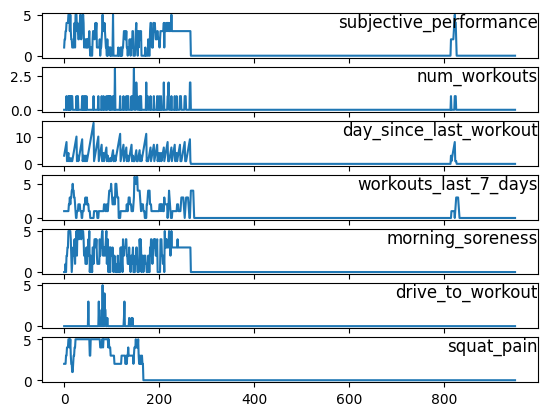

In [57]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv(CLEANED_INPUT_DATA_FILE, header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

# LSTM Prediction Model
Normalizing data, framing this as a supervised learning problem, etc.

In [58]:
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
 if i == 0:
     names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
     names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
 return agg
 
# load dataset
dataset = read_csv(CLEANED_INPUT_DATA_FILE, header=0, index_col=0)
print('list(dataset.columns.values):', list(dataset.columns.values))
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag days to train
n_days = 1
n_features = 19
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

list(dataset.columns.values): ['subjective_performance', 'num_workouts', 'day_since_last_workout', 'workouts_last_7_days', 'workouts_last_14_days', 'morning_soreness', 'drive_to_workout', 'squat_pain', 'bicep_pain', 'time_workout', 'misc_active_time', 'alpha_lipoic_l_cartinine', 'l_arginine_l_citrulline', 'zinc_mg', 'iron_mg', 'vitamin_d3_mg', 'b3_mg', 'multivtamin', 'alcohol']
(950, 38)


In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 365 * 24
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
from numpy import concatenate
from math import sqrt
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)